Computes source terms and $C_\ell$ spectrum for the two fluid model ($\Lambda$CDM with tight coupling between baryons and photons and no neutrinos). This implementation improves upon 2fluid_v0 by precomputing bessel functions and their derivatives, leading to a signficant speedup in computing the $C_\ell$ power spectrum. Also, $a_{eq}$ has been changed from OmegaGamma/OmegaM to OmegaRad/OmegaM.

In [40]:
from scipy import integrate
from scipy import interpolate
from scipy.special import spherical_jn
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

In [41]:
# Tristan's params
h0 = 0.67
H0 = 100.*h0
OmegaGamma = 2.47e-5/(h0**2.)
OmegaNu = 1.68e-5/(h0**2.)
OmegaRad = OmegaGamma + OmegaNu
OmegaCDM = 0.1201/(h0**2.)
OmegaB = 0.0223/(h0**2.)
OmegaM = OmegaCDM + OmegaB
OmegaLambda = 1-(OmegaCDM + OmegaB + OmegaGamma)
aeq = OmegaGamma/OmegaM
aeq = OmegaRad/OmegaM 

In [42]:
def eta_itgd(a):
    """Conformal time integrand"""
    return 1/(a**2. * H0 * 
              np.sqrt( OmegaM/(a**3) + OmegaRad/(a**4) + OmegaLambda)
             )

# compute conformal time today
(eta_today,_) = integrate.quad(eta_itgd, 0, 1)

# compute conformal time at recombination
(eta_rec,_) = integrate.quad(eta_itgd, 0, 10.**(-3.))

# compute eta_eq
(eta_eq,_) = integrate.quad(eta_itgd, 0, aeq)

In [43]:
zrec = lambda OmB: 1000*OmB**(-0.027/(1 + 0.11 * np.log(OmB)))  
arec = 1/(1 + zrec(OmegaB))
tau_r = 1/(np.sqrt(OmegaM/arec)*H0/2)
zeq  = 1/aeq - 1
alpha = np.sqrt(arec/aeq)
xrec = (np.sqrt((alpha**2 + 1)) - 1)/alpha
xeq = eta_eq/tau_r

In [44]:
# x is time coordinate
# y is scale factor relative to equality
def y(x): return (alpha*x)**2 + 2*alpha*x
def a(x): return aeq*y(x) 
def yb(x): return 1.68*y(x)*OmegaB/OmegaM
def yc(x): return y(x)*OmegaCDM/OmegaM
def eta(x):
    return 2*alpha*(alpha*x + 1)/(alpha**2 * x**2 + 2*alpha*x)
def delta_phi(x):
    return (2-8/y(xrec) + 16*xrec/y(xrec)**3)/(10*y(xrec))
xs = 0.6*OmegaM**(.25) * OmegaB**(-.5)*arec**(.75)*h0**(-.5)

In [45]:
# initialize arrays and "it"
SW = np.zeros(1000)
ISW = np.zeros(1000)
DOP = np.zeros(1000)
KAPPA = np.zeros(1000)
it = 0

i_range = np.linspace(0,4,1000)
for i in i_range:
    kappa = tau_r * 10**i / eta_today
    xi = np.min([10**-4 / kappa, xeq/10000])
    phi_i = 1
    delta_gamma_i = -2*phi_i*(1 + 3*y(xi)/16)
    delta_c_i = .75 * delta_gamma_i
    v_gamma_i = -kappa/eta(xi) * (
        delta_gamma_i/4 + (2*kappa**2 * (1 + y(xi))*phi_i)/
                        (9*eta(xi)**2 * (4./3. +y(xi))))
    
    # solve the ODE
    def d_func(x, Y):
        """return function derivatives"""
        delta_c = Y[0]
        vc = Y[1]
        delta_gamma = Y[2]
        v_gamma = Y[3]
        phi = Y[4]
        
        DY = np.zeros(5)
        DY[4] = -eta(x) * phi + (3*eta(x)**2*(v_gamma*
                        (4./3. +y(x)-yc(x))+yc(x)*vc))/(2*(1+y(x))*kappa)
        DY[0] = -kappa * vc + 3*DY[4]
        DY[1] = -eta(x)*vc+kappa*phi
        DY[2] = -4./3. * kappa *v_gamma + 4*DY[4]
        DY[3] = (-eta(x)*yb(x)*v_gamma + kappa*delta_gamma/3)/(
            4./3. + yb(x)) + kappa*phi
        
        return DY
    
    x_span = [xi, xrec]
    Y0 = [delta_c_i, v_gamma_i, delta_gamma_i, v_gamma_i, phi_i]
    out = integrate.solve_ivp(d_func, x_span, Y0)
    sol = out['y']
    
    # fill arrays
    KAPPA[it] = kappa
    SW[it] = sol[4, -1] + sol[2, -1]/4.
    ISW[it] = 2*delta_phi(xrec)
    DOP[it] = sol[3, -1]
    it += 1
SW_terp = interpolate.interp1d(KAPPA, -SW * np.exp(-KAPPA**2 * xs**2))
ISW_terp = interpolate.interp1d(KAPPA, -ISW * np.exp(-KAPPA**2 * xs**2))
DOP_terp = interpolate.interp1d(KAPPA, -DOP * np.exp(-KAPPA**2 * xs**2))

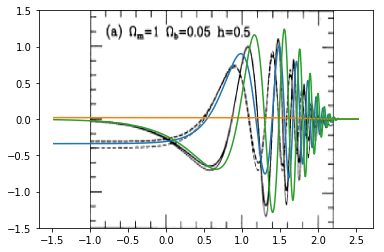

In [46]:
"""Compare to Seljak"""
im = plt.imread('seljak_1.png')
implot = plt.imshow(im, extent=[-1,2.2,-1.5,1.5],aspect='auto',zorder=0)

plt.plot(np.log10(KAPPA), -SW * np.exp(-KAPPA**2 * xs**2))
plt.plot(np.log10(KAPPA), -ISW * np.exp(-KAPPA**2 * xs**2))
plt.plot(np.log10(KAPPA), -DOP * np.exp(-KAPPA**2 * xs**2))
plt.show()

In [47]:
eta_star = eta_rec

In [48]:
k_list = np.arange(15914)*tau_r*2 * np.pi/(10 * eta_today) + tau_r/eta_today
ell_list = np.array([2,3,4,5,6,7,8,10,12,15]+list(range(20,100,10))+
                    list(range(120,500,20)) + list(range(550,1250,50))) 

In [49]:
# precompute all bessels:
J_lk = np.zeros((len(ell_list),len(k_list)))
DJ_lk = np.zeros((len(ell_list),len(k_list)))
k_scaled = k_list*(eta_today-eta_star)/tau_r
for i in range(len(k_list)):
    J_lk[:,i] = spherical_jn(ell_list,k_scaled[i])
    DJ_lk[:,i] = .5*(spherical_jn(ell_list + 1, k_scaled[i]) - spherical_jn(ell_list - 1, k_scaled[i]))

In [50]:
Cl_intgd =(np.exp(-2*k_list**2. * xs**2)*
            ((SW_terp(k_list) + ISW_terp(k_list))*
            J_lk + DOP_terp(k_list)*
            (-(J_lk/(2*k_scaled))+
            DJ_lk))**2)
Cl_list = integrate.cumtrapz(Cl_intgd/k_list, axis=1)[:,-1]

In [51]:
Cl_terp = interpolate.interp1d(ell_list, Cl_list)
Cl_terp_quad = interpolate.interp1d(ell_list, Cl_list, kind='quadratic')
l_range = np.linspace(2, 1200, 1000)
plot_vals = Cl_terp(l_range)*l_range * (l_range+1) / (2 * (2+1) * Cl_terp(2))
plot_vals_2 = Cl_terp_quad(l_range)*l_range * (l_range+1) / (2 * (2+1) * Cl_terp_quad(2))

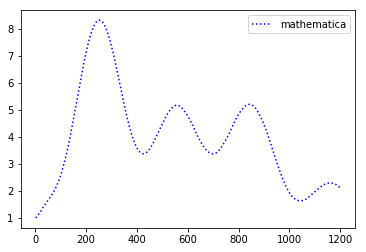

In [52]:
"""Compare C_l to mathematica"""
#mat_data = genfromtxt('matdat.csv', delimiter=',')
#plt.plot(mat_data[:,0],mat_data[:,1],color='orange')
plt.plot(l_range, plot_vals_2,color='blue',linestyle=':')
plt.legend(['mathematica','python'])


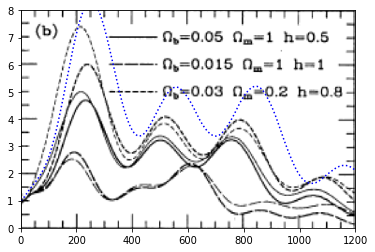

In [53]:
"""Compare C_l to Seljak"""
plt.plot(l_range, plot_vals_2,color='blue',linestyle=':',zorder=1)
im = plt.imread('seljak_2.png')
implot = plt.imshow(im, extent=[0,1200,0,8],zorder=0,aspect='auto')
plt.show()